In [ ]:
pip install ta

In [ ]:
# import all libraries
from google.colab import files
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice
import math
import pandas as pd
import numpy as np
import yfinance as yf

In [ ]:
uploaded = files.upload()

Saving final_stock_data.csv to final_stock_data (1).csv


In [ ]:
df_stocks_return = pd.read_csv('final_stock_data.csv')

In [ ]:
df_stocks_return.head()

,Symbol,Company,Industry,CurrentDate,CurrentPrice,Low52Weeks,High52Weeks,MA50,MA150,MA200,MA200PastMonth
0,KDP,Keurig Dr Pepper Inc,Consumer Staples,2016-01-04,12.536439,9.468566,12.911597,12.252658,11.101465,10.911483,10.687746
1,GOOG,Alphabet Inc Class C,Communication,2016-01-04,37.091999,24.560070,38.830002,36.983150,32.396300,31.048140,30.052798
2,EQIX,Equinix Reit Inc,Real Estate,2016-01-04,256.065857,175.784866,263.762970,255.340109,235.071762,227.281094,220.355792
3,NVDA,Nvidia Corp,Information Technology,2016-01-04,7.900972,4.595530,8.237809,7.625126,6.150517,5.928999,5.668378
4,TSN,Tyson Foods Inc Class A,Consumer Staples,2016-01-04,44.966877,31.527924,45.807465,41.560863,38.066816,37.006023,35.878735


In [ ]:
unique_stocks = df_stocks_return['Symbol'].unique()

In [ ]:
# Check to see if the symbols obtained are legitimate
stock_prices = {}
for stock in unique_stocks:
    stock_prices[stock] = yf.Ticker(stock).history(start = '2010-01-01', end = '2015-12-31')['Close']

stock_prices['KDP']

Date
2010-01-04 00:00:00-05:00     3.327762
2010-01-05 00:00:00-05:00     3.288882
2010-01-06 00:00:00-05:00     3.362068
2010-01-07 00:00:00-05:00     3.325475
2010-01-08 00:00:00-05:00     3.301461
                               ...    
2015-12-23 00:00:00-05:00    12.756639
2015-12-24 00:00:00-05:00    12.766156
2015-12-28 00:00:00-05:00    12.821885
2015-12-29 00:00:00-05:00    12.911595
2015-12-30 00:00:00-05:00    12.865383
Name: Close, Length: 1509, dtype: float64

In [ ]:
temp = pd.DataFrame()
for key,value in stock_prices.items():
    temp[key] = value
temp = temp.reset_index().drop('Date', axis = 1)

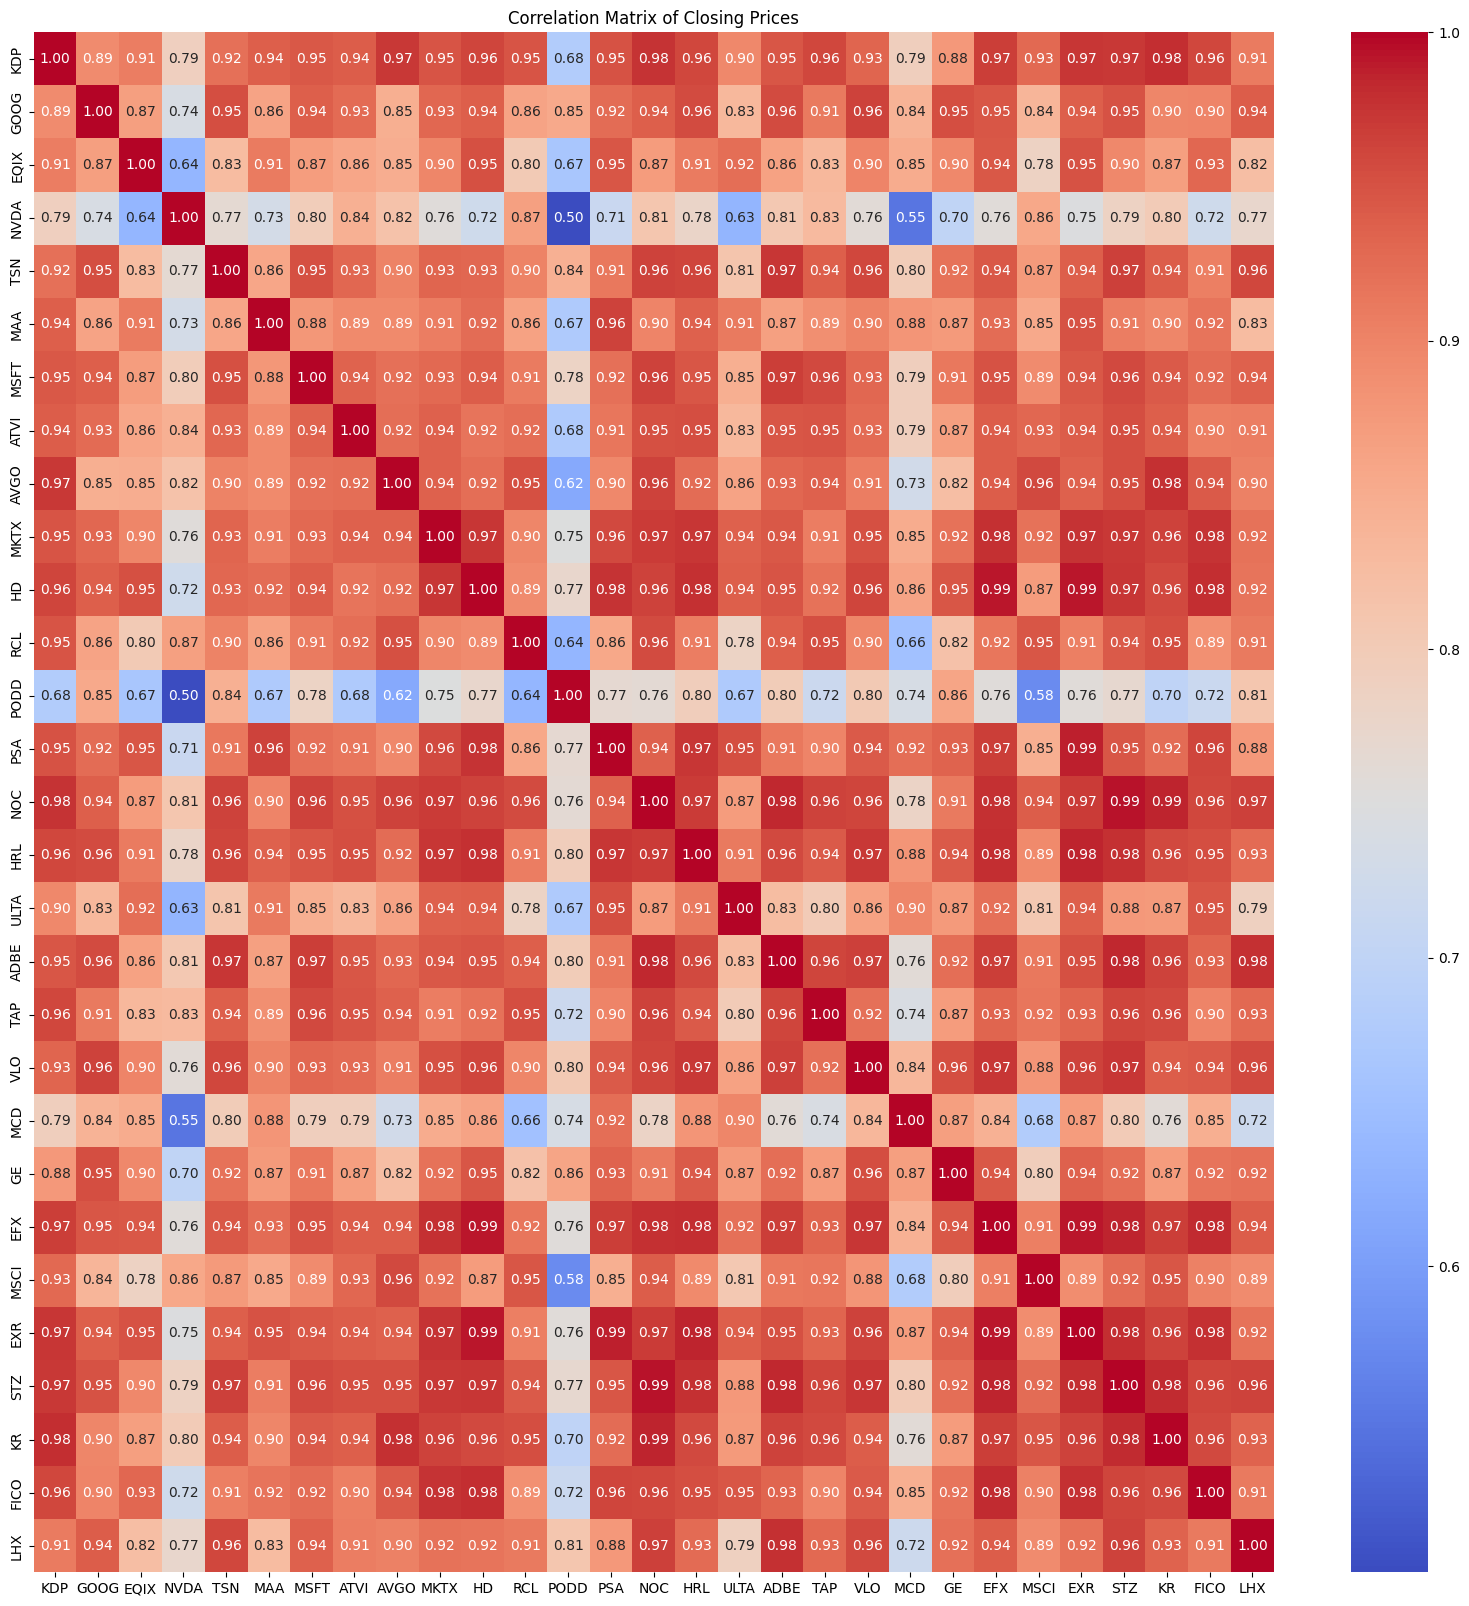

In [ ]:
correlation_matrix = temp.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Closing Prices')
plt.show()

The top 10 correlated stocks are: **NVDA, PODD, MCD, MSCI, AVGO, ULTA, EQIX, RCL, MAA, KDP**.

In [ ]:
class Common_Class():
  """
  A common class to calculate the results for all strategies.
  Key Terms;
      - A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
  Methods in class:
  1. prepare_data()
      - Loads the close prices of all stocks and calculates the return of each stock
  2. close_graph(stock)
      - A line plot showcasing the close prices of all stocks over the stated period (start - end)
  3. return_date_price(stock)
      - Returns the date and price of the stock at that given date
  4. realised_balance(bar)
      - Returns the realised capital in your account in a given bar
  5. unrealised_balance(bar)
      - Returns the unrealised capital in your account in a given bar
  6. total_balance(bar)
      - Unrealised + Realised
  7. store_results()
          - Stores the results in a dataframe
  8. performance()
      - Calculates the performance ratios that is used to evaluate performance of strategy
      - Ratios used:
          1. Sharpe Ratio
          2, ROI (Return on investment)
          3. Drawdown
  9. performance_plots()
      - Visualisations of returns of stocks VS strategy
      - Plot 1: Movement of close prices of all stocks over stated period
      - Plot 2: Histogram of strategy returns
      - Plot 3: Strategy vs Instrument returns
      - Plot 4: Drawdown
      - Plot 5: Equity Curve
  10. buy_order()
      - Conducts a buy order upon fulfilling buy conditions of strategy
  11. sell_order()
      - Conducts a sell order upon fulfilling sell conditions of strategy
  12. last_trade()
      - Checks the last trade conducted
  """
  def __init__(self, symbol, start, end, interval, capital, transcation_cost, verbose = True):

    #new dicts as now there will be multiple stocks. Each stock will have its own position/quantity etc
    self.all_data ={}
    self.position = {}
    self.quantity = {}
    self.stoptrade = {}
    self.boughtprice = {}

    for stock in symbol:
      self.quantity['{}'.format(stock)] = 0 #can also do at run strategy, but its different design

    self.symbol = symbol
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital # this is the initial capital you want to trade with
    self.capital = capital # this capital will change depending on trades
    self.transaction_cost = transcation_cost # the transaction cost for trading
    self.trades = 0 # Number of trades
    self.verbose = verbose # if you want to see detailed output (logs)
    self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # to store trade details

    self.prepare_data() # prepares the data

  def prepare_data(self):
    # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
    # we will calculate the returns though.
    # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.

    for i in self.symbol:
      stock_data = yf.Ticker(i)
      hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
      bt_data = pd.DataFrame()
      bt_data["Close_Price"] = hist_stock["Close"]
      bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
      bt_data = bt_data.dropna()
      self.all_data['{}'.format(i)] = bt_data

  def close_graph(self, stock):
    i = str(stock)
    plt.figure(figsize=(15, 5))
    plt.plot(self.all_data[i]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of {}".format(i))
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, bar, stock): #now we will also pass the stock as parameter
    # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
    # Since we have modeled close prices, we will get the price and date
    i = str(stock)
    date = str(self.all_data[i].index[bar])[:10]  # :10 to only get the date
    price = self.all_data[i].Close_Price.iloc[bar]
    return date, price

  def realised_balance(self, bar):
    #returns the realised capital in your account at a given time period / bar
    date, price = self.return_date_price(bar, self.symbol[0]) # only concerned with date so any stock will do
    print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

  def unrealised_balance(self, bar):
    #returns you the unrealised capital (trades in progress) in your account at a given time period / bar
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub =  ub + self.quantity['{}'.format(stock)] *price
    #print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

  def total_balance(self, bar):
    #Unrealised plus realised
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub =  ub + self.quantity['{}'.format(stock)] *price
    tb = ub + self.capital
    #print("Date :{} | Total Balance: {:0.1f}".format(date,tb))
    return tb

  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol), 'quantity':pd.Series(quantity), 'capital':pd.Series(capital) })
    self.stored_data = pd.concat([self.stored_data, trade_detail])

  def performance_plots(self):# once we have dataframe of daily account balances
    Final_result_data = self.Final_result_data #saving time to write self everywhere
    interval = str(self.interval)
    f,ax = plt.subplots(2,3,figsize=(20,10))

    #plot 1: Close Price os stock
    plt.subplot(2, 3, 1)
    for stock in self.symbol:
      plt.plot(Final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
    plt.title("Cum Log returns of included stocks")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 2: Histogram of dtrstegy returns
    plt.subplot(2, 3, 2)
    plt.hist(Final_result_data['capital_log_returns'], bins = 35, label='Strategy Returns', linestyle='dashed')
    plt.title("Histogram of Strategy returns")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 3: Strategy vs Instrument
    plt.subplot(2, 3, 3)
    plt.plot(Final_result_data['Total_Stock_Returns_cum_sum'],color='red', label='Equal weighted stock Returns', linestyle='dashed')
    plt.plot(Final_result_data['capital_regular_returns_cumsum'].dropna(), label ='Strategy Returns')
    plt.title("Strategy Vs Stock Cum Return Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 4: Drawdown
    plt.subplot(2, 3, 4)
    plt.plot(Final_result_data["capital_returns_log_cum_sum"].dropna(), label='Cum log returns')
    plt.plot(Final_result_data["Cum_Max"].dropna(), label =  'Max Drawdown')
    plt.title("Drawdown")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 5: Equity Curve
    plt.subplot(2, 3,  5)
    plt.plot(Final_result_data["capital"].dropna(), label =  'Equity $')
    plt.title("Equity Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    plt.suptitle("Performance Plots")
    f.delaxes(ax[1,2]) # to delete the last subplot

    plt.show()

  def performance(self):
    # stored data has  [trade, date, position, price, symbol, quantity, capital]
    #B = self.stored_data # this will have many rows ; n(number of instruments) times more
    #C = self.all_data # will need this to aggregate the returns from all stocks
    #B.index = range(B.shape[0]/len(self.symbol))

    #Since the stocks are not stored in arranged manner, we need to arrange them so that we can get the entry price and exit price for each day
    #stored data has many rows, we will aggregate day wise

    df = pd.DataFrame() # creating a new datframe to store aggregated values

    df['capital'] = self.stored_data.groupby('date').agg({'capital': 'mean'})
    # agrregating by mean because the run is done in loop (for all stocks in a list of symbols),
    # so each stock "date" will have the same capital accounting for all stocks
    # you can print and see different metrics..

    # df.index = range(self.stored_data.shape[0]/len(self.symbol)) # shape[0] to get the length of rows of each stock and make an index for dataframe df

    trade_start_date = df['capital'].index[0] # If intraday, then index needs to be adjusted with time, for daily, its fine
    trade_end_date = df['capital'].index[-1] # This will work when interval is 1D

    #Also, since we have multiple stocks, we need to calculate expected returns to comapre against the strategy

    for stock in self.symbol:
      A = (self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist()) # The returns are already log
      df['Returns_{}'.format(stock)] = A
    c= df.columns #fetch all the columns of dataframe
    df['Total_Stock_Returns'] = (df.loc[:,c[-len(self.symbol):]].sum(1))/len(self.symbol) # Sums up last N columns of df and divide by number of stocks. Equal weightage
    df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
    df.index = range(df.shape[0])

    df['capital_after_settlement'] = df['capital'].shift(-1)

    # Since we are are utilising capital, we will calculate returns for SR based on daily capital/equity changes
    #Remember, you can change the returns on investment based on the capital you trade

    df['capital_regular_returns'] = (df['capital_after_settlement']/df['capital'] - 1)
    df['capital_regular_returns_cumsum'] = df['capital_regular_returns'].cumsum()
    df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
    df["capital_returns_log_cum_sum"] = df["capital_log_returns"].cumsum()

    # for drawdown calculation
    df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
    df["drawdown"] = df["Cum_Max"] - df["capital_returns_log_cum_sum"]
    # The maximum difference is refered as "Drawdown"

    df.drop(df.index[df['capital_log_returns'] == 0.0], inplace=True) #Dropping the last column, as I already got the values through shift(1)
    df = df.dropna()
    #print(df.head())

    '''
    #arranging the columns for better readeability
    cols =['trade','symbol','position','quantity','date', 'exit_date', 'price','exit_price',\
           'price_log_returns','price_log_returns_cum_sum','capital',\
          'capital_after_settlement', 'capital_regular_returns', 'capital_log_returns',\
           'capital_returns_log_cum_sum','Cum_Max','drawdown']
    B = B[cols]
    B.rename(columns = {'date':'entry_date', 'price':'entry_price'}, inplace = True)

    '''

    #storing the results in Final_result data
    Final_result_data = df
    #Final_result_data.head()

    #Plot the equity curve
    #plt.plot(Final_result_data['exit_date'],Final_result_data['capital_after_settlement'])
    #Final_result_data[['exit_date', 'capital_after_settlement']].dropna().plot(figsize =(15,6), title = "Equity /Capital Plot")

    print("=" *50)
    print("Performance Metrics")

    #Total Balance
    print("The total capital at end of strategy: {:0.1f}".format(self.capital))

    # Annual gross expected returns
    daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

    # Annual std deviation
    daily_regular_std = (np.exp(Final_result_data['capital_log_returns'])-1).std()
    annual_regular_std =  daily_regular_std * (252 **0.5) *100
    print("The annual regular std deviation: {:0.2f} %".format(annual_regular_std))

    #Annual Sharpe Ratio
    SR = annual_regular_return / annual_regular_std
    print("The annual Sharpe Ratio: {:0.2f}".format(SR))

    #The strategy returns on investment in percent

    #Total_Log_ret = Final_result_data['capital_log_returns'].sum()
    #Total_Log_ret
    #Regular_ROI = (np.exp(Total_Log_ret) - 1) *100
    #print("The returns on investment from {} to {} by this strategy is {:0.2f} %".format(self.start, self.end, Regular_ROI))

    # the above method will also produce same result

    returns = (self.capital - self.initial_capital) /self.initial_capital *100
    print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, returns))

    #Calculate Drawdown
    #Final_result_data[["capital_returns_log_cum_sum", "Cum_Max"]].dropna().plot(figsize =(15,6), title = "Drawdown Plot")

    Drawdown = Final_result_data["drawdown"].max()*100
    print("The maximum drawdown: {:.2f} %".format(Drawdown))

    zero_periods = Final_result_data[Final_result_data['drawdown'] == 0]
    delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
    print("The maximum drawdown period: {:.2f} days".format(delta_values.max()))

    #Annual Sortino Ratio
    #Calculate the sortino ratio from the Final result data
    #sortino = ...
    #print("The annual Sortino Ratio: {:0.2f}".format(sortino))

    #Calculate any other ratio you want...

    #Total trades
    print("The total trades taken by the strategy: {}".format(self.trades))


    print("=" *50)

    self.Final_result_data = Final_result_data
    #print(self.Final_result_data.head())


  def buy_order(self,bar,stock,quantity=None, dollar =None ):
    date, price = self.return_date_price(bar,stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] + quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = 1
    tb = self.total_balance(bar)
    #self.quantity['{}'.format(stock)]*price + self.capital # this is just for one stock, however, I need for all the stocks
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)
    self.boughtprice['{}'.format(stock)] = price


    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
      self.realised_balance(bar)
      #self.unrealised_balance(bar)
      #self.total_balance(bar)


  def sell_order(self,bar,stock, quantity=None, dollar=None ):
    date, price = self.return_date_price(bar, stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] - quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = -1
    tb = self.total_balance(bar) # to store the total balance due to all the stocks at the end of the day, so that I get 1 value at the EOD
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)
    self.boughtprice['{}'.format(stock)] = price


    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
      self.realised_balance(bar)
      #self.unrealised_balance(bar)
      #self.total_balance(bar)

  def last_trade(self, bar):# thi sneeds to be check for all open positions of all stocks

    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      last_quantity = self.quantity['{}'.format(stock)]
      self.capital = self.capital + last_quantity * price
      self.quantity['{}'.format(stock)] = 0 # as no more quantity now. all will be settled
      self.trades = self.trades +1
      if self.position['{}'.format(stock)] == -1: # if closing out a short position
        last_quantity = - last_quantity # to keep a positve nymber in records. Note, self.quantity is always maintianing a +/- sign.
        self.position['{}'.format(stock)] = 1 # to record we are buying to close out
      else:
        last_quantity =  last_quantity # to keep a positve nymber in records
        self.position['{}'.format(stock)] = -1 # to record we are selling to close out
      #self.position = 0
      tb = self.total_balance(bar)
      self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, last_quantity, tb)

      if self.verbose:
        print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,stock, price, last_quantity * price))

**Strategy: RSI & MA Crossover strategy:**

---



Long term / Slow
Short Term / Fast


Rule -->
        
        Short Term Moving Average Crosses above a Long Term Moving Average or RSI < lower bound -> Buy/Long

        Short Term Moving Average Crosses below a Long Term Moving Average or RSI > upper bound -> Sell/Short

        Stop Loss: stop_loss% below the bought-in price
        Take Profit: take_profit% higher than the bought-at price

Variables --> Short MA / Long MA / RSI window / lower bound / upper bound / stop_loss / take_profit


In [ ]:
class MA_RSI_Strategy(Common_Class):
  """
    A class dictating our strategy conditions and the corresponding actions. This class inherits the Common_Class above.
    Methods in class:
    1. go_long(bar, stock):
        - Actions to conduct when a long position is taken
    2. go_short(bar, stock):
        - Actions to conduct when a short position is taken
    3. run_strategy(STMA_window, LTMA_window, RSI_window, upper_bound, lower_bound, stop_loss, take_profit):
        - Strategy conditions:
            - Long: LTMA > STMA and RSI < lower_bound
            - Short: LTMA < STMA and RSI > upper_bound
  """

  def go_long(self, bar, stock, quantity = None, dollar = None): # either previously in position or fresh position
    if self.position['{}'.format(stock)] == -1:
      self.position['{}'.format(stock)] = 0
      self.buy_order(bar,stock, quantity = -self.quantity['{}'.format(stock)]) #to clear previous short position and therefore negative quantity.(already in position, thats why negative)
      if dollar == 0: # stop loss or take profit condition
        self.stoptrade['{}'.format(stock)] = -1
        return None
    if quantity:
      self.buy_order (bar, stock, quantity = quantity) # to create new fresh order
      self.stoptrade['{}'.format(stock)] = 0
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      else:
        dollar = self.capital/len(self.symbol)
      self.buy_order(bar, stock, dollar = dollar)
      self.stoptrade['{}'.format(stock)] = 0

  def go_short(self, bar, stock, quantity = None, dollar = None):
    if self.position['{}'.format(stock)] == 1:
      self.position['{}'.format(stock)] = 0
      self.sell_order(bar,stock, quantity = self.quantity['{}'.format(stock)]) #to clear previous long vposition
      if dollar == 0: # stop loss or take profit condition
        self.stoptrade['{}'.format(stock)] = 1
        return None
    if quantity:
      self.sell_order (bar, stock, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      else:
        dollar = self.capital/len(self.symbol)
      self.sell_order(bar, stock, dollar = dollar)
      self.stoptrade['{}'.format(stock)] = 0

  def run_strategy(self, STMA_window, LTMA_window, RSI_window, upper_bound, lower_bound, stop_loss, take_profit): # add the parameters according to the strategy
    self.stop = False # I will use this to make sure NO trading when balance = 0 OR lost all money
    self.trades = 0
    self.capital = self.initial_capital


    #Preparing data with LTMA and STMA so that can check crossovers. Also initialising with 0 quantity and 0 position

    for stock in self.symbol:
      self.quantity['{}'.format(stock)] = 0
      self.position['{}'.format(stock)] = 0

      indicator_1 = SMAIndicator(close = self.all_data['{}'.format(stock)]["Close_Price"], window = STMA_window, fillna= False)
      STMA = indicator_1.sma_indicator()

      indicator_2 = SMAIndicator(close = self.all_data['{}'.format(stock)]["Close_Price"], window = LTMA_window, fillna= False)
      LTMA = indicator_2.sma_indicator()

      self.all_data['{}'.format(stock)]['STMA_{}'.format(stock)] = STMA
      self.all_data['{}'.format(stock)]['LTMA_{}'.format(stock)] = LTMA

      C = RSIIndicator(close = self.all_data['{}'.format(stock)]["Close_Price"], window= RSI_window, fillna = False)
      self.all_data['{}'.format(stock)]['RSI_{}'.format(stock)] = C.rsi()

      #initialise the bought-in price and indicator for take profit/stop loss
      self.stoptrade['{}'.format(stock)] = 0 #1 indicates a previous take profit/stop loss action at long position, -1 indicates a previous action at short positin
      date, price = self.return_date_price(max(LTMA_window, RSI_window), stock) #initialise with first price
      self.boughtprice['{}'.format(stock)] = price

    for bar in range(max(LTMA_window, RSI_window), len(self.all_data['{}'.format(self.symbol[0])])): # from the available data bar to the last data bar
      #Making a func so that no trade if balance goes below 0

      tb = self.total_balance(bar)
      if tb < 0:
        print("negative capital")
        self.last_trade(bar)
        self.stop = True
        break

      for stock in self.symbol:
        date, price = self.return_date_price(bar, stock)


        if self.position['{}'.format(stock)] in [0,-1]: # checking no position or short position
          if self.position['{}'.format(stock)] in [-1]: # check for price change to stop loss/take profit when in position
            # buy to stop loss or take profit
            if price/self.boughtprice['{}'.format(stock)] - 1 >= stop_loss or price/self.boughtprice['{}'.format(stock)] - 1 <= -take_profit:
              self.go_long(bar,stock, dollar = 0)
          # go long if condition is satisfied and the previous trade is not take profit/stop loss at long position
          if (self.all_data['{}'.format(stock)]['STMA_{}'.format(stock)].iloc[bar] > self.all_data['{}'.format(stock)]['LTMA_{}'.format(stock)].iloc[bar]\
          or self.all_data['{}'.format(stock)]['RSI_{}'.format(stock)].iloc[bar] < lower_bound) and self.stoptrade['{}'.format(stock)] != 1:
             self.go_long(bar,stock, dollar = self.capital/len(self.symbol)) # go with equal money # Make sure to enter less than initila capital
             #print("--------")
             continue # as I am storing data for SR calculations. Dont wnat duplication

        if self.position['{}'.format(stock)] in [0,1]: # checking no position or long position
          if self.position['{}'.format(stock)] in [1]: # check for price change to stop loss/take profit when in position
            # sell to stop loss or take profit
            if price/self.boughtprice['{}'.format(stock)] - 1 <= -stop_loss or price/self.boughtprice['{}'.format(stock)] - 1 >= take_profit:
              self.go_short(bar,stock, dollar = 0)
          if (self.all_data['{}'.format(stock)]['STMA_{}'.format(stock)].iloc[bar] < self.all_data['{}'.format(stock)]['LTMA_{}'.format(stock)].iloc[bar]\
            or self.all_data['{}'.format(stock)]['RSI_{}'.format(stock)].iloc[bar] > upper_bound) and self.stoptrade['{}'.format(stock)] != -1:
            self.go_short(bar,stock, dollar =self.capital/len(self.symbol)) # go with equal money
            #print("--------")
            continue

        #-----Storing all the values for calculating Sharpe-----
        store_quantity = abs(self.quantity['{}'.format(stock)]) # so that I want just the positive numbers in my performance table. I will calculate +/- based on position sign
        tb = self.total_balance(bar)
        self.store_results(0, date, self.position['{}'.format(stock)], price, stock, store_quantity, tb)

    #print("=" *50)
    #print("End of last bar") Now the bar ends, bar is at the last bar value.
    #print("=" *50)
    if self.stop == False: # to make sure not to run this func 2 times when early exit due to negative balance
      self.last_trade(bar)  # amke sure the crossover happens, give more time


Performance Metrics
The total capital at end of strategy: 634915.8
The annual regular returns: 4.71 %
The annual regular std deviation: 7.25 %
The annual Sharpe Ratio: 0.65
The returns on investment from 2010-01-01 to 2015-12-31 by this strategy is 27.0 %
The maximum drawdown: 21.84 %
The maximum drawdown period: 857.00 days
The total trades taken by the strategy: 2001


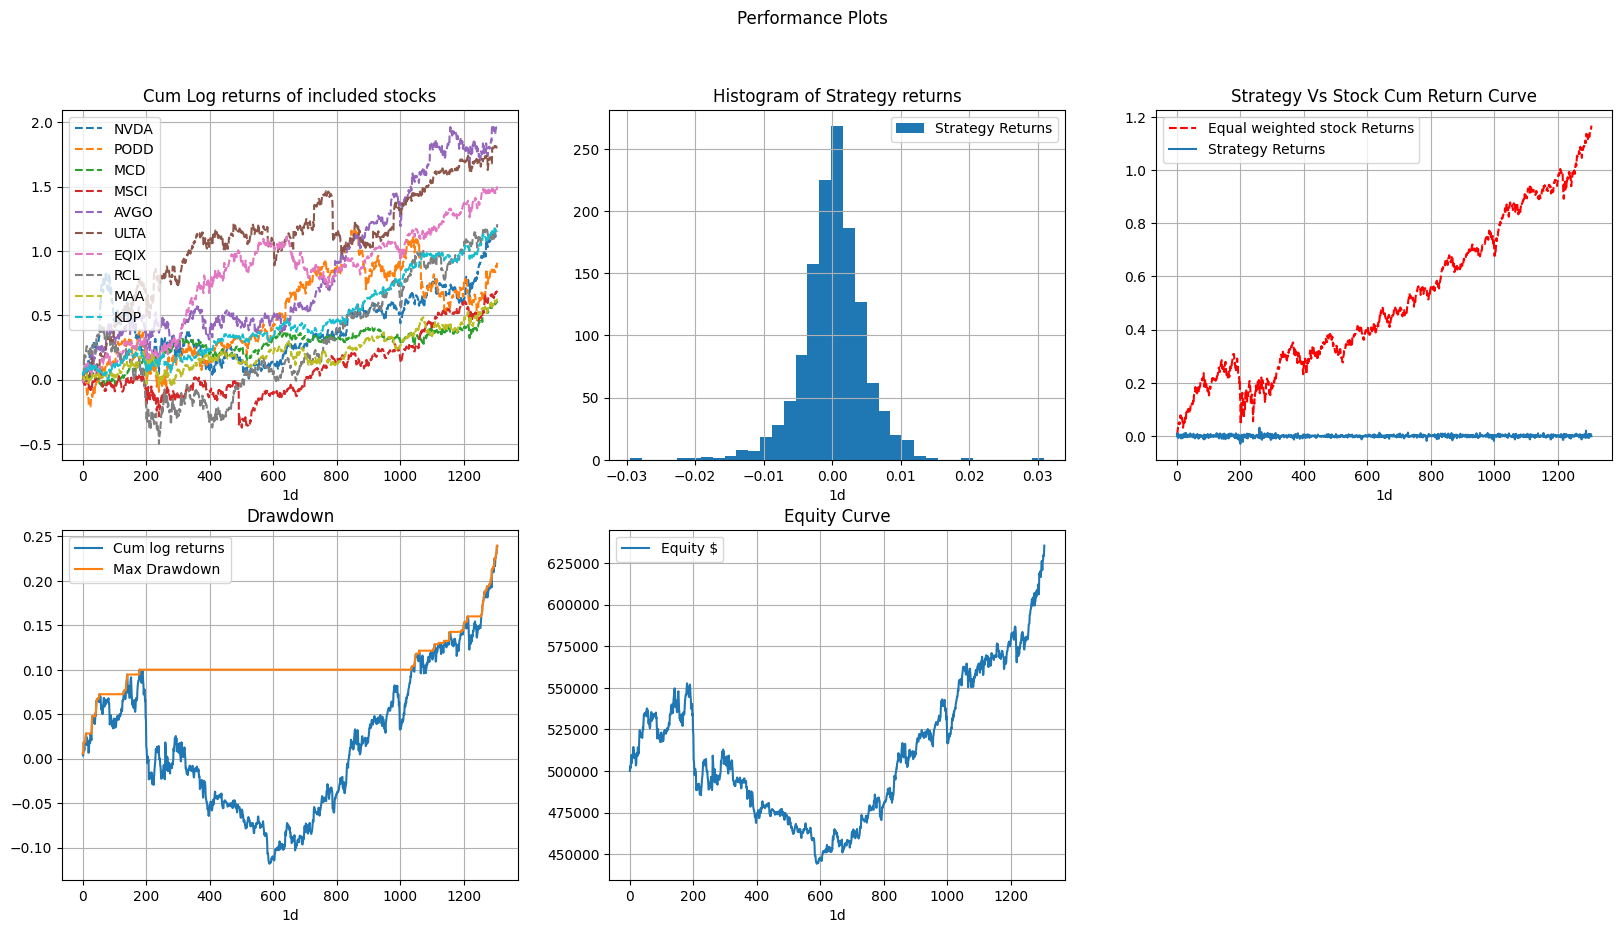

In [ ]:
# Test the strategy class
if __name__ == "__main__":
  stocks = ['NVDA', 'PODD', 'MCD', 'MSCI', 'AVGO', 'ULTA', 'EQIX', 'RCL', 'MAA', 'KDP']
  A = MA_RSI_Strategy(stocks, '2010-01-01', '2015-12-31',"1d", 500000, 0.00, False)
  A.run_strategy(50,200, 15, 70, 30, 0.1, 0.15)
  A.performance()
  A.performance_plots()

## Backtesting for variation selection

### Variations:

**Moving average period (short term, long term)** = [20, 50], [20, 100], [20, 150], [50,100], [50, 150], [50, 200]

**RSI window** = 6, 10, 15, 20, 25

**RSI lower and upper bound** = [20, 70], [20, 80], [30, 70], [30,80]

**stop loss ratio** = 0.05, 0.1, 0.15, 0.2, 0.25

**take profit ratio** = 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5

In [ ]:
# Variation of parameters for training
RSI_window_lst = [6, 10, 15] # RSI window is set to be lower than default for short-term trading
ma_period = [[20, 50], [20, 100],[20, 150]]
bound_lst = [[20, 80], [30, 80], [20, 70], [30, 70]]

model_param_20 = []
model_result_20 = []

# Initialising stocks
stocks = ['NVDA', 'PODD', 'MCD', 'MSCI', 'AVGO', 'ULTA', 'EQIX', 'RCL', 'MAA', 'KDP']
for RSI_window in RSI_window_lst:
  for STMA_window, LTMA_window in ma_period:
    for lower_bound, upper_bound in bound_lst:
      A = MA_RSI_Strategy(stocks, '2010-01-01', '2015-12-31',"1d", 500000, 0.00, False)
      A.run_strategy(STMA_window, LTMA_window, RSI_window, upper_bound, lower_bound, 1, 1)
      print(STMA_window, LTMA_window, RSI_window, upper_bound, lower_bound, 1, 1)
      A.performance()
      model_param_20.append([STMA_window, LTMA_window, RSI_window, upper_bound, lower_bound, 1, 1])
      model_result_20.append((A.capital - A.initial_capital) /A.initial_capital *100)


20 50 6 80 20 1 1
Performance Metrics
The total capital at end of strategy: 416949.0
The annual regular returns: -3.09 %
The annual regular std deviation: 11.29 %
The annual Sharpe Ratio: -0.27
The returns on investment from 2010-01-01 to 2015-12-31 by this strategy is -16.6 %
The maximum drawdown: 35.42 %
The maximum drawdown period: 193.00 days
The total trades taken by the strategy: 3250
20 50 6 80 30 1 1
Performance Metrics
The total capital at end of strategy: 505348.0
The annual regular returns: 0.18 %
The annual regular std deviation: 11.66 %
The annual Sharpe Ratio: 0.02
The returns on investment from 2010-01-01 to 2015-12-31 by this strategy is 1.1 %
The maximum drawdown: 28.38 %
The maximum drawdown period: 104.00 days
The total trades taken by the strategy: 4226
20 50 6 70 20 1 1
Performance Metrics
The total capital at end of strategy: 537685.1
The annual regular returns: 1.26 %
The annual regular std deviation: 11.48 %
The annual Sharpe Ratio: 0.11
The returns on investmen

In [ ]:
# Variation of parameters for training
RSI_window_lst = [6, 10, 15] # RSI window is set to be lower than default for short-term trading
ma_period = [[50, 100], [50, 150], [50, 200]]
bound_lst = [[20, 80], [30, 80], [20, 70], [30, 70]]

model_param_50 = []
model_result_50 = []

# Initialising stocks
stocks = ['NVDA', 'PODD', 'MCD', 'MSCI', 'AVGO', 'ULTA', 'EQIX', 'RCL', 'MAA', 'KDP']
for RSI_window in RSI_window_lst:
  for STMA_window, LTMA_window in ma_period:
    for lower_bound, upper_bound in bound_lst:
        A = MA_RSI_Strategy(stocks, '2010-01-01', '2015-12-31',"1d", 500000, 0.00, False)
        A.run_strategy(STMA_window, LTMA_window, RSI_window, upper_bound, lower_bound, 1, 1)
        print(STMA_window, LTMA_window, RSI_window, upper_bound, lower_bound, 1, 1)
        A.performance()
        model_param_50.append([STMA_window, LTMA_window, RSI_window, upper_bound, lower_bound, 1, 1])
        model_result_50.append((A.capital - A.initial_capital) /A.initial_capital *100)


50 100 6 80 20 1 1
Performance Metrics
The total capital at end of strategy: 682125.1
The annual regular returns: 5.72 %
The annual regular std deviation: 10.36 %
The annual Sharpe Ratio: 0.55
The returns on investment from 2010-01-01 to 2015-12-31 by this strategy is 36.4 %
The maximum drawdown: 23.47 %
The maximum drawdown period: 784.00 days
The total trades taken by the strategy: 2448
50 100 6 80 30 1 1
Performance Metrics
The total capital at end of strategy: 759082.9
The annual regular returns: 7.76 %
The annual regular std deviation: 10.34 %
The annual Sharpe Ratio: 0.75
The returns on investment from 2010-01-01 to 2015-12-31 by this strategy is 51.8 %
The maximum drawdown: 17.34 %
The maximum drawdown period: 404.00 days
The total trades taken by the strategy: 3164
50 100 6 70 20 1 1
Performance Metrics
The total capital at end of strategy: 898202.4
The annual regular returns: 11.06 %
The annual regular std deviation: 10.73 %
The annual Sharpe Ratio: 1.03
The returns on investm

In [ ]:
model_result_arr_20 = np.array(model_result_20)
sorted_index_20 = np.argsort(model_result_arr_20)
sorted_index_20 = np.flip(sorted_index_20) # Output the indexes rank by returns
sorted_index_20 = sorted_index_20.tolist()

model_result_arr_50 = np.array(model_result_50)
sorted_index_50 = np.argsort(model_result_arr_50)
sorted_index_50 = np.flip(sorted_index_50) # Output the indexes rank by returns
sorted_index_50 = sorted_index_50.tolist()

In [ ]:
# Output top 10 returns and parameters
for index in sorted_index_20[0:10]:
  print('Model params for STMA = 20 are '+",".join(str(param) for param in model_param_20[index]))
  print('Model return for STMA = 20 is '+ str(model_result_20[index]) + '%.')

print("----------------------------------------------------")

# Output top 10 returns and parameters
for index in sorted_index_50[0:10]:
  print('Model params for STMA = 50 are '+",".join(str(param) for param in model_param_50[index]))
  print('Model return for STMA = 50 is '+ str(model_result_50[index]) + '%.')

Model params for STMA = 20 are 20,150,6,70,30,1,1
Model return for STMA = 20 is 67.30749040923118%.
Model params for STMA = 20 are 20,100,6,70,30,1,1
Model return for STMA = 20 is 49.86518988585472%.
Model params for STMA = 20 are 20,150,6,70,20,1,1
Model return for STMA = 20 is 45.97137440962791%.
Model params for STMA = 20 are 20,100,6,70,20,1,1
Model return for STMA = 20 is 35.415352086877824%.
Model params for STMA = 20 are 20,50,6,70,30,1,1
Model return for STMA = 20 is 33.01982095718384%.
Model params for STMA = 20 are 20,150,10,70,30,1,1
Model return for STMA = 20 is 32.68382516336441%.
Model params for STMA = 20 are 20,150,15,70,20,1,1
Model return for STMA = 20 is 32.66669104037285%.
Model params for STMA = 20 are 20,150,6,80,30,1,1
Model return for STMA = 20 is 30.26181169958115%.
Model params for STMA = 20 are 20,150,10,70,20,1,1
Model return for STMA = 20 is 26.686853414440154%.
Model params for STMA = 20 are 20,150,15,70,30,1,1
Model return for STMA = 20 is 23.592849167156

From backtesting, we found that

A short-term window = **50**, long-term window = **100**, RSI window = **6**, upper bound= **70**, lower bound= **30** gives a _return on investment_ of **101.38%.**

We will now add the variations for stop loss and take profit ratio:
stop_loss_lst = [0.05, 0.1, 0.15, 0.2, 0.25]

take_profit_lst = [0.05, 0.1, 0.15, 0.2]

In [ ]:
# Set variations for iteration
RSI_window_lst = [6, 20, 25] #RSI window is set to be lower than default for short-term trading
ma_period = [[50, 100], [50, 200]]
bound_lst = [[20, 80], [30, 70]]
stop_loss_lst = [0.15, 0.2, 0.25]
take_profit_lst = [0.05, 0.1, 0.15]

model_param = []
model_result = []

# initialising stocks
stocks = ['NVDA', 'PODD', 'MCD', 'MSCI', 'AVGO', 'ULTA', 'EQIX', 'RCL', 'MAA', 'KDP']


for stop_loss in stop_loss_lst:
  for take_profit in take_profit_lst:
    A = MA_RSI_Strategy(stocks, '2010-01-01', '2015-12-31',"1d", 500000, 0.00, False)
    A.run_strategy(50, 100, 6, 70, 30, stop_loss, take_profit)
    print(stop_loss, take_profit)
    A.performance()
    model_param.append([stop_loss, take_profit])
    model_result.append((A.capital - A.initial_capital) /A.initial_capital *100)



0.15 0.05
Performance Metrics
The total capital at end of strategy: 951984.9
The annual regular returns: 12.22 %
The annual regular std deviation: 8.73 %
The annual Sharpe Ratio: 1.40
The returns on investment from 2010-01-01 to 2015-12-31 by this strategy is 90.4 %
The maximum drawdown: 15.85 %
The maximum drawdown period: 377.00 days
The total trades taken by the strategy: 5777
0.15 0.1
Performance Metrics
The total capital at end of strategy: 899752.5
The annual regular returns: 11.10 %
The annual regular std deviation: 8.60 %
The annual Sharpe Ratio: 1.29
The returns on investment from 2010-01-01 to 2015-12-31 by this strategy is 80.0 %
The maximum drawdown: 12.85 %
The maximum drawdown period: 368.00 days
The total trades taken by the strategy: 5612
0.15 0.15
Performance Metrics
The total capital at end of strategy: 911533.0
The annual regular returns: 11.36 %
The annual regular std deviation: 7.95 %
The annual Sharpe Ratio: 1.43
The returns on investment from 2010-01-01 to 2015-1

In [ ]:
model_result_arr = np.array(model_result)
sorted_index = np.argsort(model_result_arr)
sorted_index = np.flip(sorted_index) # output the indexes rank by returns
sorted_index = sorted_index.tolist()

In [ ]:
#output top 10 returns and parameters
for index in sorted_index[0:10]:
  print('Model params are '+",".join(str(param) for param in model_param[index]))
  print('Model return is '+ str(model_result[index]) + '%.')

Model params are 0.25,0.05
Model return is 105.45315182981491%.
Model params are 0.25,0.15
Model return is 94.0895243200779%.
Model params are 0.15,0.05
Model return is 90.39697906880379%.
Model params are 0.25,0.1
Model return is 88.4948800813198%.
Model params are 0.15,0.15
Model return is 82.30659828147888%.
Model params are 0.15,0.1
Model return is 79.95050534000396%.
Model params are 0.2,0.1
Model return is 78.59954667453766%.
Model params are 0.2,0.05
Model return is 73.85692728877068%.
Model params are 0.2,0.15
Model return is 72.43006961135863%.


### Optimal Variation is:

**Moving average period (short term, long term)** = 50, 100

**RSI window** = 6

**RSI lower and upper bound** = 30, 70

**stop loss ratio**= 0.25

**take profit ratio** = 0.05

### Training Performance




Performance Metrics
The total capital at end of strategy: 1027264.9
The annual regular returns: 13.76 %
The annual regular std deviation: 9.96 %
The annual Sharpe Ratio: 1.38
The returns on investment from 2010-01-01 to 2015-12-31 by this strategy is 105.5 %
The maximum drawdown: 13.28 %
The maximum drawdown period: 307.00 days
The total trades taken by the strategy: 6189


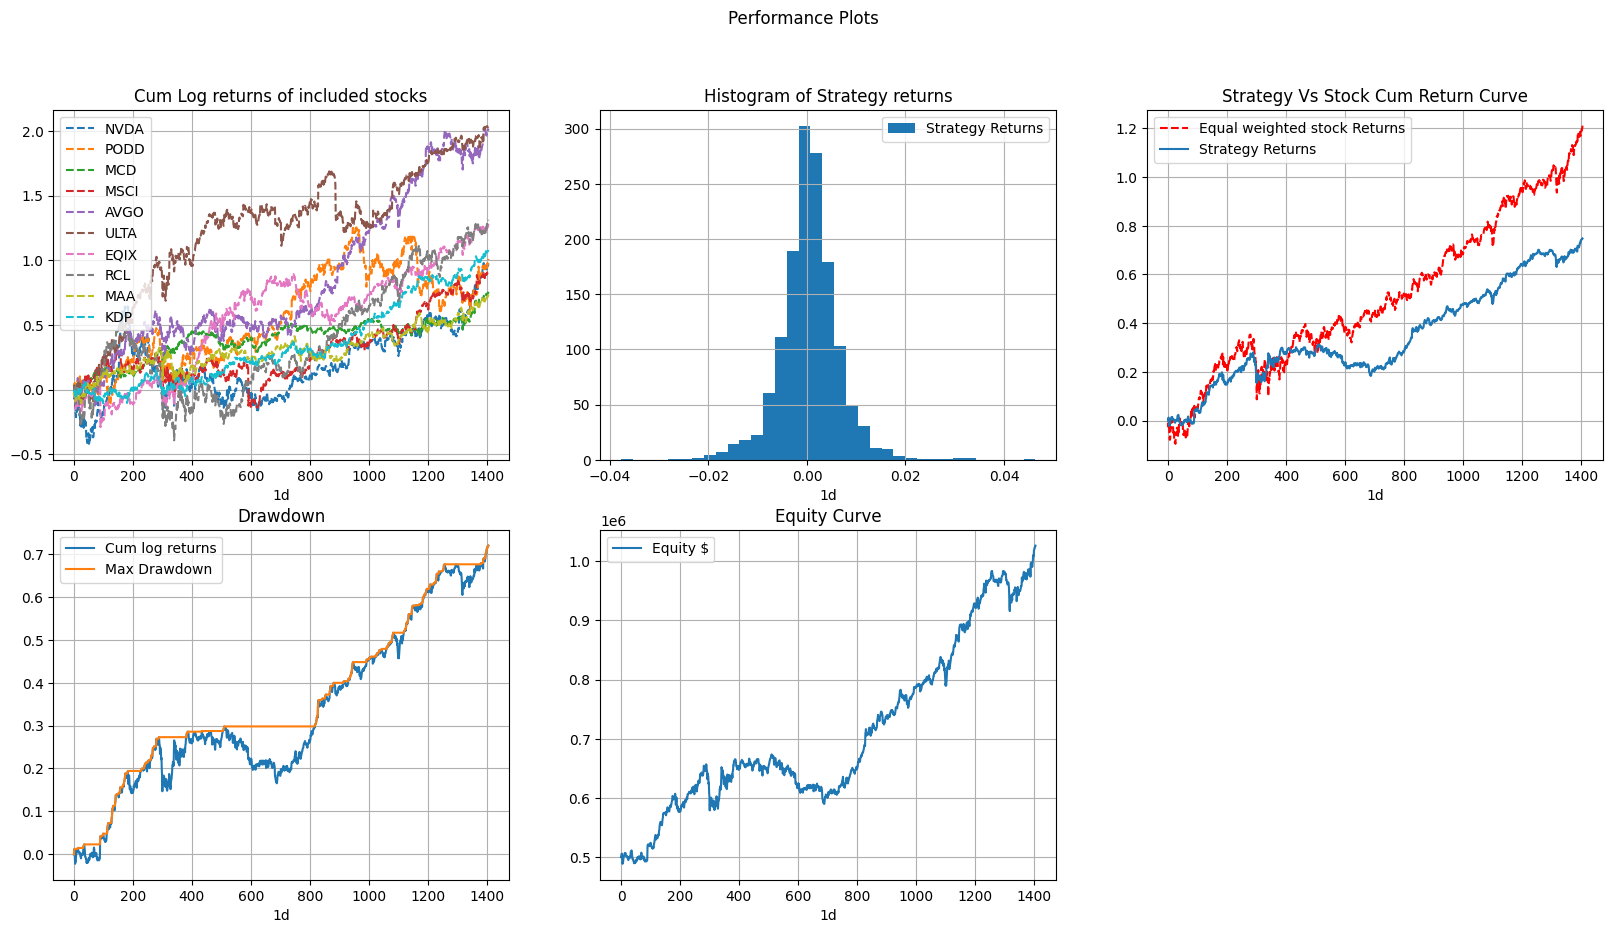

In [ ]:
stocks = ['NVDA', 'PODD', 'MCD', 'MSCI', 'AVGO', 'ULTA', 'EQIX', 'RCL', 'MAA', 'KDP']
A = MA_RSI_Strategy(stocks, '2010-01-01', '2015-12-31',"1d", 500000, 0.00, False)
A.run_strategy(50,100, 6, 70, 30, 0.25, 0.05)
A.performance()
A.performance_plots()

In [ ]:
# Compare to benchmark
df = pd.DataFrame()
df['benchmark'] = yf.Ticker('^GSPC').history(start='2010-01-01', end='2015-12-31').Close
df['benchmark_return'] = np.log(df["benchmark"] / df["benchmark"].shift(1))

# Annual gross expected returns
daily_log_mean_ret = df['benchmark_return'].mean()
annual_log_ret = 252 * daily_log_mean_ret
annual_regular_return = (np.exp(annual_log_ret) -1)*100
print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

# Annual std deviation
daily_regular_std = (np.exp(df['benchmark_return'])-1).std()
annual_regular_std =  daily_regular_std * (252 **0.5) *100
print("The annual regular std deviation: {:0.2f} %".format(annual_regular_std))

#Annual Sharpe Ratio
SR = annual_regular_return / annual_regular_std
print("The annual Sharpe Ratio: {:0.2f}".format(SR))

returns = (df['benchmark'].iloc[-1] - df['benchmark'].iloc[0]) /df['benchmark'].iloc[0] *100
print("The returns on investment from 2010-01-01 to 2015-12-31 on benchmark is {:0.1f} %".format(returns))

#Calculate Drawdown
df["benchmark_returns_log_cum_sum"] = df['benchmark_return'].cumsum()

# for drawdown calculation
df["Cum_Max"] = df["benchmark_returns_log_cum_sum"].cummax()
df["drawdown"] = df["Cum_Max"] - df["benchmark_returns_log_cum_sum"]

Drawdown = df["drawdown"].max()*100
print("The maximum drawdown: {:.2f} %".format(Drawdown))

zero_periods = df[df['drawdown'] == 0]
delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
print("The maximum drawdown period: ", str(delta_values.max())[:8])

The annual regular returns: 10.54 %
The annual regular std deviation: 15.91 %
The annual Sharpe Ratio: 0.66
The returns on investment from 2010-01-01 to 2015-12-31 on benchmark is 82.1 %
The maximum drawdown: 21.55 %
The maximum drawdown period:  301 days


## Testing

Performance Metrics
The total capital at end of strategy: 559939.5
The annual regular returns: 3.21 %
The annual regular std deviation: 8.38 %
The annual Sharpe Ratio: 0.38
The returns on investment from 2016-01-01 to 2019-12-31 by this strategy is 12.0 %
The maximum drawdown: 19.79 %
The maximum drawdown period: 183.00 days
The total trades taken by the strategy: 4204


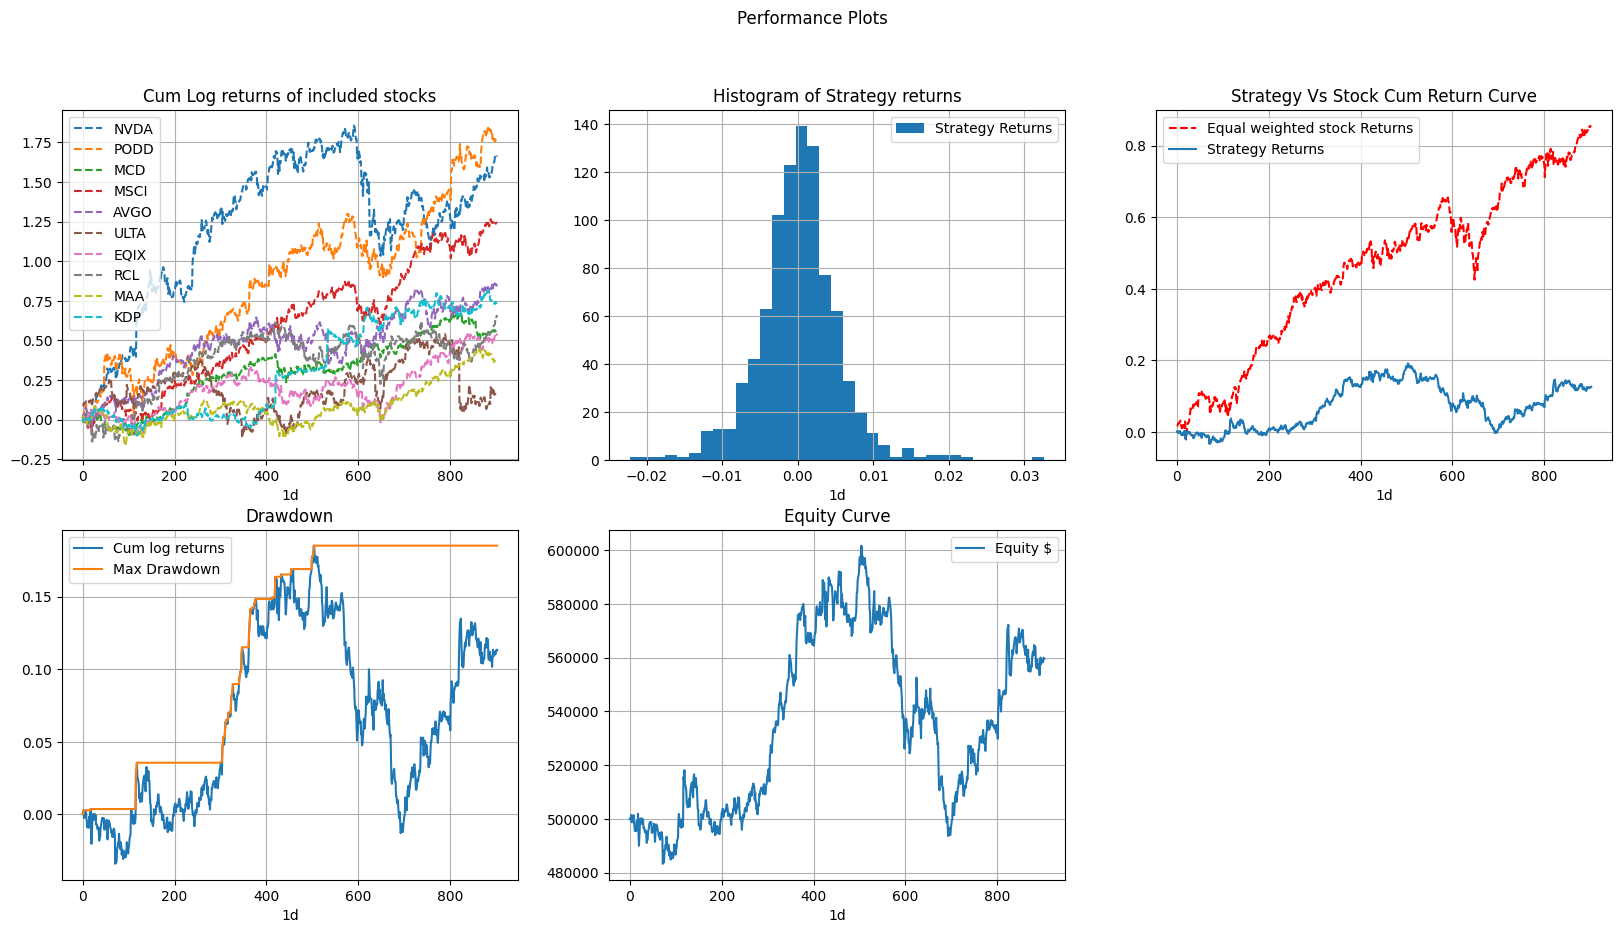

In [ ]:
stocks = ['NVDA', 'PODD', 'MCD', 'MSCI', 'AVGO', 'ULTA', 'EQIX', 'RCL', 'MAA', 'KDP']
A = MA_RSI_Strategy(stocks, '2016-01-01', '2019-12-31',"1d", 500000, 0.00, False)
A.run_strategy(50,100, 6, 70, 30, 0.25, 0.05)
A.performance()
A.performance_plots()

###Benchmark Performance
SP500 is used as benchmark.

In [ ]:
df = pd.DataFrame()
df['benchmark'] = yf.Ticker('^GSPC').history(start='2016-01-01', end='2019-12-31').Close
df['benchmark_return'] = np.log(df["benchmark"] / df["benchmark"].shift(1))

# Annual gross expected returns
daily_log_mean_ret = df['benchmark_return'].mean()
annual_log_ret = 252 * daily_log_mean_ret
annual_regular_return = (np.exp(annual_log_ret) -1)*100
print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

# Annual std deviation
daily_regular_std = (np.exp(df['benchmark_return'])-1).std()
annual_regular_std =  daily_regular_std * (252 **0.5) *100
print("The annual regular std deviation: {:0.2f} %".format(annual_regular_std))

#Annual Sharpe Ratio
SR = annual_regular_return / annual_regular_std
print("The annual Sharpe Ratio: {:0.2f}".format(SR))

returns = (df['benchmark'].iloc[-1] - df['benchmark'].iloc[0]) /df['benchmark'].iloc[0] *100
print("The returns on investment from 2016-01-01 to 2019-12-31 on benchmark is {:0.1f} %".format(returns))

#Calculate Drawdown
df["benchmark_returns_log_cum_sum"] = df['benchmark_return'].cumsum()

# for drawdown calculation
df["Cum_Max"] = df["benchmark_returns_log_cum_sum"].cummax()
df["drawdown"] = df["Cum_Max"] - df["benchmark_returns_log_cum_sum"]

Drawdown = df["drawdown"].max()*100
print("The maximum drawdown: {:.2f} %".format(Drawdown))

zero_periods = df[df['drawdown'] == 0]
delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
print("The maximum drawdown period: ", str(delta_values.max())[:8])

The annual regular returns: 12.53 %
The annual regular std deviation: 12.86 %
The annual Sharpe Ratio: 0.97
The returns on investment from 2016-01-01 to 2019-12-31 on benchmark is 60.1 %
The maximum drawdown: 22.04 %
The maximum drawdown period:  215 days
